In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

In [2]:
datadir = 'data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', None)
data.head()

center  \
0  C:\Users\sudharsan\Desktop\codes\python_programs\udemy_self_driving_car\data\IMG\center_2020_07_10_20_10_22_002.jpg   
1  C:\Users\sudharsan\Desktop\codes\python_programs\udemy_self_driving_car\data\IMG\center_2020_07_10_20_10_22_103.jpg   
2  C:\Users\sudharsan\Desktop\codes\python_programs\udemy_self_driving_car\data\IMG\center_2020_07_10_20_10_22_207.jpg   
3  C:\Users\sudharsan\Desktop\codes\python_programs\udemy_self_driving_car\data\IMG\center_2020_07_10_20_10_22_309.jpg   
4  C:\Users\sudharsan\Desktop\codes\python_programs\udemy_self_driving_car\data\IMG\center_2020_07_10_20_10_22_413.jpg   

                                                                                                                 left  \
0   C:\Users\sudharsan\Desktop\codes\python_programs\udemy_self_driving_car\data\IMG\left_2020_07_10_20_10_22_002.jpg   
1   C:\Users\sudharsan\Desktop\codes\python_programs\udemy_self_driving_car\data\IMG\left_2020_07_10_20_10_22_103.jpg   
2   C:\Users\sudharsan\Desktop\codes\python_programs\udemy_self_driving_car\data\IMG\left_2020_07_10_20_10_22_207.jpg   
3   C:\Users\sudharsan\Desktop\codes\python_programs\udemy_self_driving_car\data\IMG\left_2020_07_10_20_10_22_309.jpg   
4   C:\Users\sudharsan\Desktop\codes\python_programs\udemy_self_driving_car\data\IMG\left_2020_07_10_20_10_22_413.jpg   

                                                                                                                 right  \
0   C:\Users\sudharsan\Desktop\codes\python_programs\udemy_self_driving_car\data\IMG\right_2020_07_10_20_10_22_002.jpg   
1   C:\Users\sudharsan\Desktop\codes\python_programs\udemy_self_driving_car\data\IMG\right_2020_07_10_20_10_22_103.jpg   
2   C:\Users\sudharsan\Desktop\codes\python_programs\udemy_self_driving_car\data\IMG\right_2020_07_10_20_10_22_207.jpg   
3   C:\Users\sudharsan\Desktop\codes\python_programs\udemy_self_driving_car\data\IMG\right_2020_07_10_20_10_22_309.jpg   
4   C:\Users\sudharsan\Desktop\codes\python_programs\udemy_self_driving_car\data\IMG\right_2020_07_10_20_10_22_413.jpg   

   steering  throttle  reverse     speed  
0       0.0       0.0      0.0  0.000082  
1       0.0       0.0      0.0  0.000082  
2       0.0       0.0      0.0  0.000082  
3       0.0       0.0      0.0  0.000082  
4       0.0       0.0      0.0  0.000082

In [3]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center                              left  \
0  center_2020_07_10_20_10_22_002.jpg  left_2020_07_10_20_10_22_002.jpg   
1  center_2020_07_10_20_10_22_103.jpg  left_2020_07_10_20_10_22_103.jpg   
2  center_2020_07_10_20_10_22_207.jpg  left_2020_07_10_20_10_22_207.jpg   
3  center_2020_07_10_20_10_22_309.jpg  left_2020_07_10_20_10_22_309.jpg   
4  center_2020_07_10_20_10_22_413.jpg  left_2020_07_10_20_10_22_413.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2020_07_10_20_10_22_002.jpg       0.0       0.0      0.0  0.000082  
1  right_2020_07_10_20_10_22_103.jpg       0.0       0.0      0.0  0.000082  
2  right_2020_07_10_20_10_22_207.jpg       0.0       0.0      0.0  0.000082  
3  right_2020_07_10_20_10_22_309.jpg       0.0       0.0      0.0  0.000082  
4  right_2020_07_10_20_10_22_413.jpg       0.0       0.0      0.0  0.000082

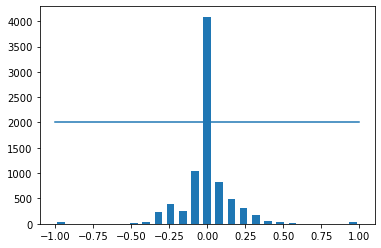

In [4]:
num_bins = 25
samples_per_bin = 2000
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+bins[1:]) * 0.5
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin,samples_per_bin))

total data 8059
removed 2088
remaining 5971


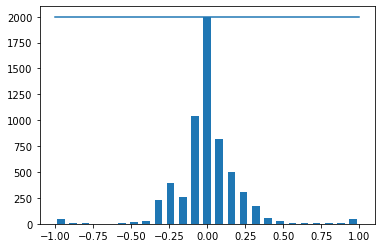

In [5]:
print('total data', len(data))

remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)
    
print('removed', len(remove_list))
data.drop(data.index[remove_list], inplace = True)
print('remaining', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin,samples_per_bin))

In [6]:
print(data.iloc[1])
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
        # left image append
        image_path.append(os.path.join(datadir,left.strip()))
        steering.append(float(indexed_data[3])+0.15)
        # right image append
        image_path.append(os.path.join(datadir,right.strip()))
        steering.append(float(indexed_data[3])-0.15)
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings
 
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2020_07_10_20_10_22_207.jpg
left          left_2020_07_10_20_10_22_207.jpg
right        right_2020_07_10_20_10_22_207.jpg
steering                                     0
throttle                                     0
reverse                                      0
speed                              8.18271e-05
Name: 2, dtype: object


In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 14330
Valid Samples: 3583


Text(0.5, 1.0, 'Validation set')

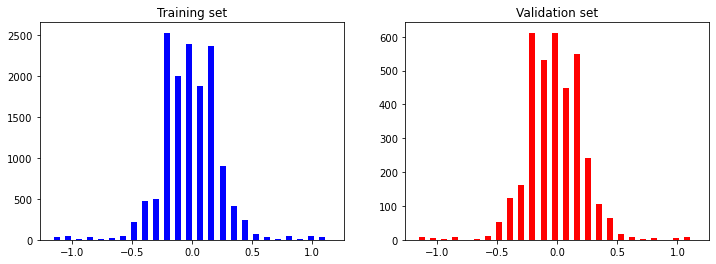

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [9]:
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image

Text(0.5, 1.0, 'Zoomed Image')

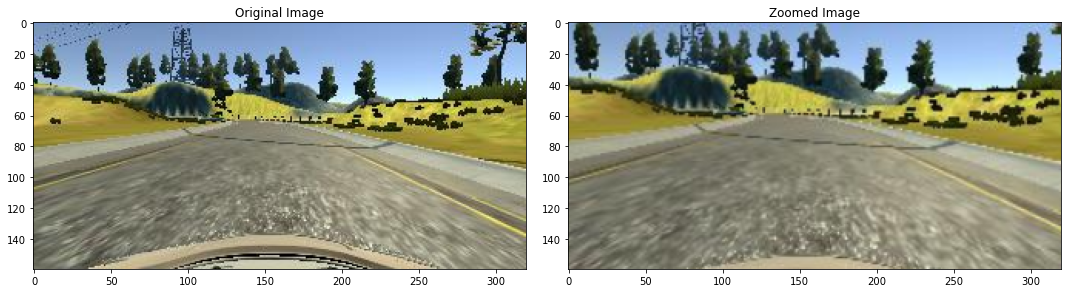

In [10]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [11]:
def pan(image):
    pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image


Text(0.5, 1.0, 'Panned Image')

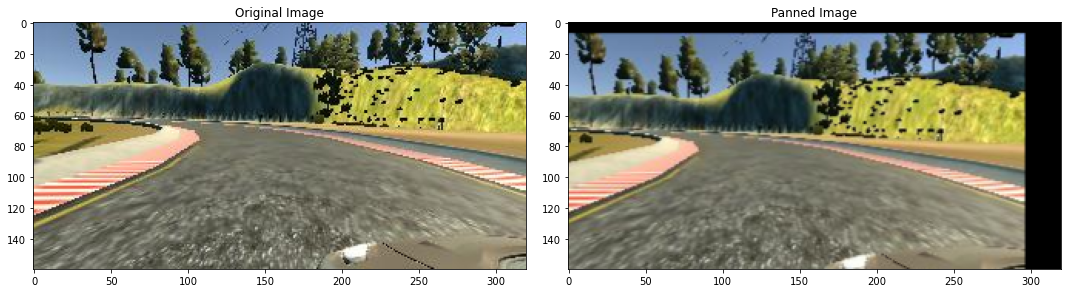

In [12]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [13]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

Text(0.5, 1.0, 'Brightness altered image ')

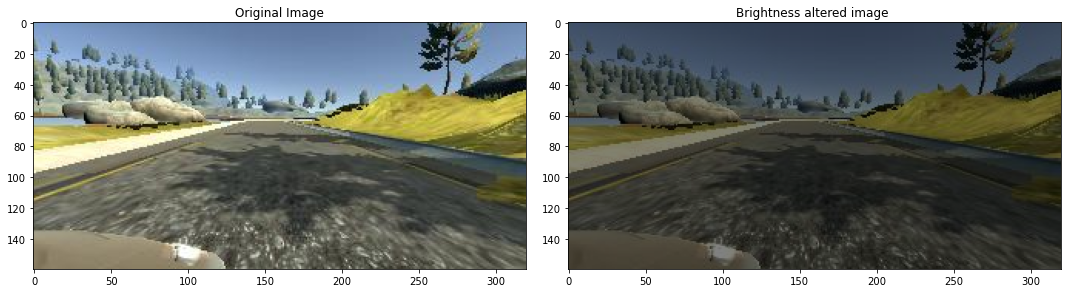

In [14]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

In [18]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1) # one for horizontal flip
    steering_angle =- steering_angle
    return image,steering_angle

Text(0.5, 1.0, 'flipped img: 0.2598527')

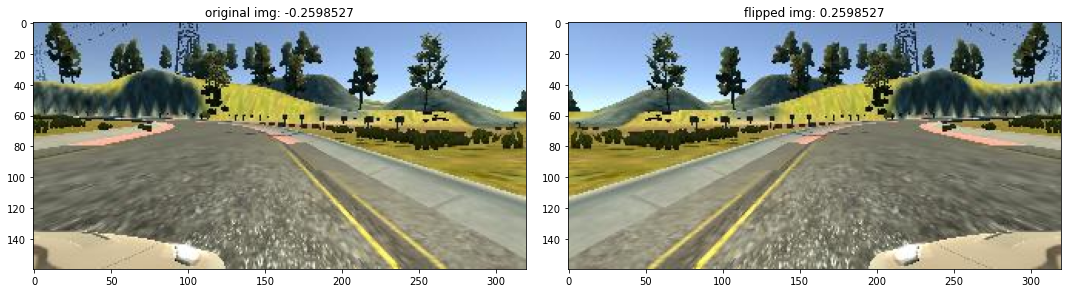

In [19]:
random_index = random.randint(0,1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axes = plt.subplots(1,2,figsize = (15,10))
fig.tight_layout()

axes[0].imshow(original_image)
axes[0].set_title('original img: '+ str(steering_angle))

axes[1].imshow(flipped_image)
axes[1].set_title('flipped img: '+ str(flipped_steering_angle))

In [20]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

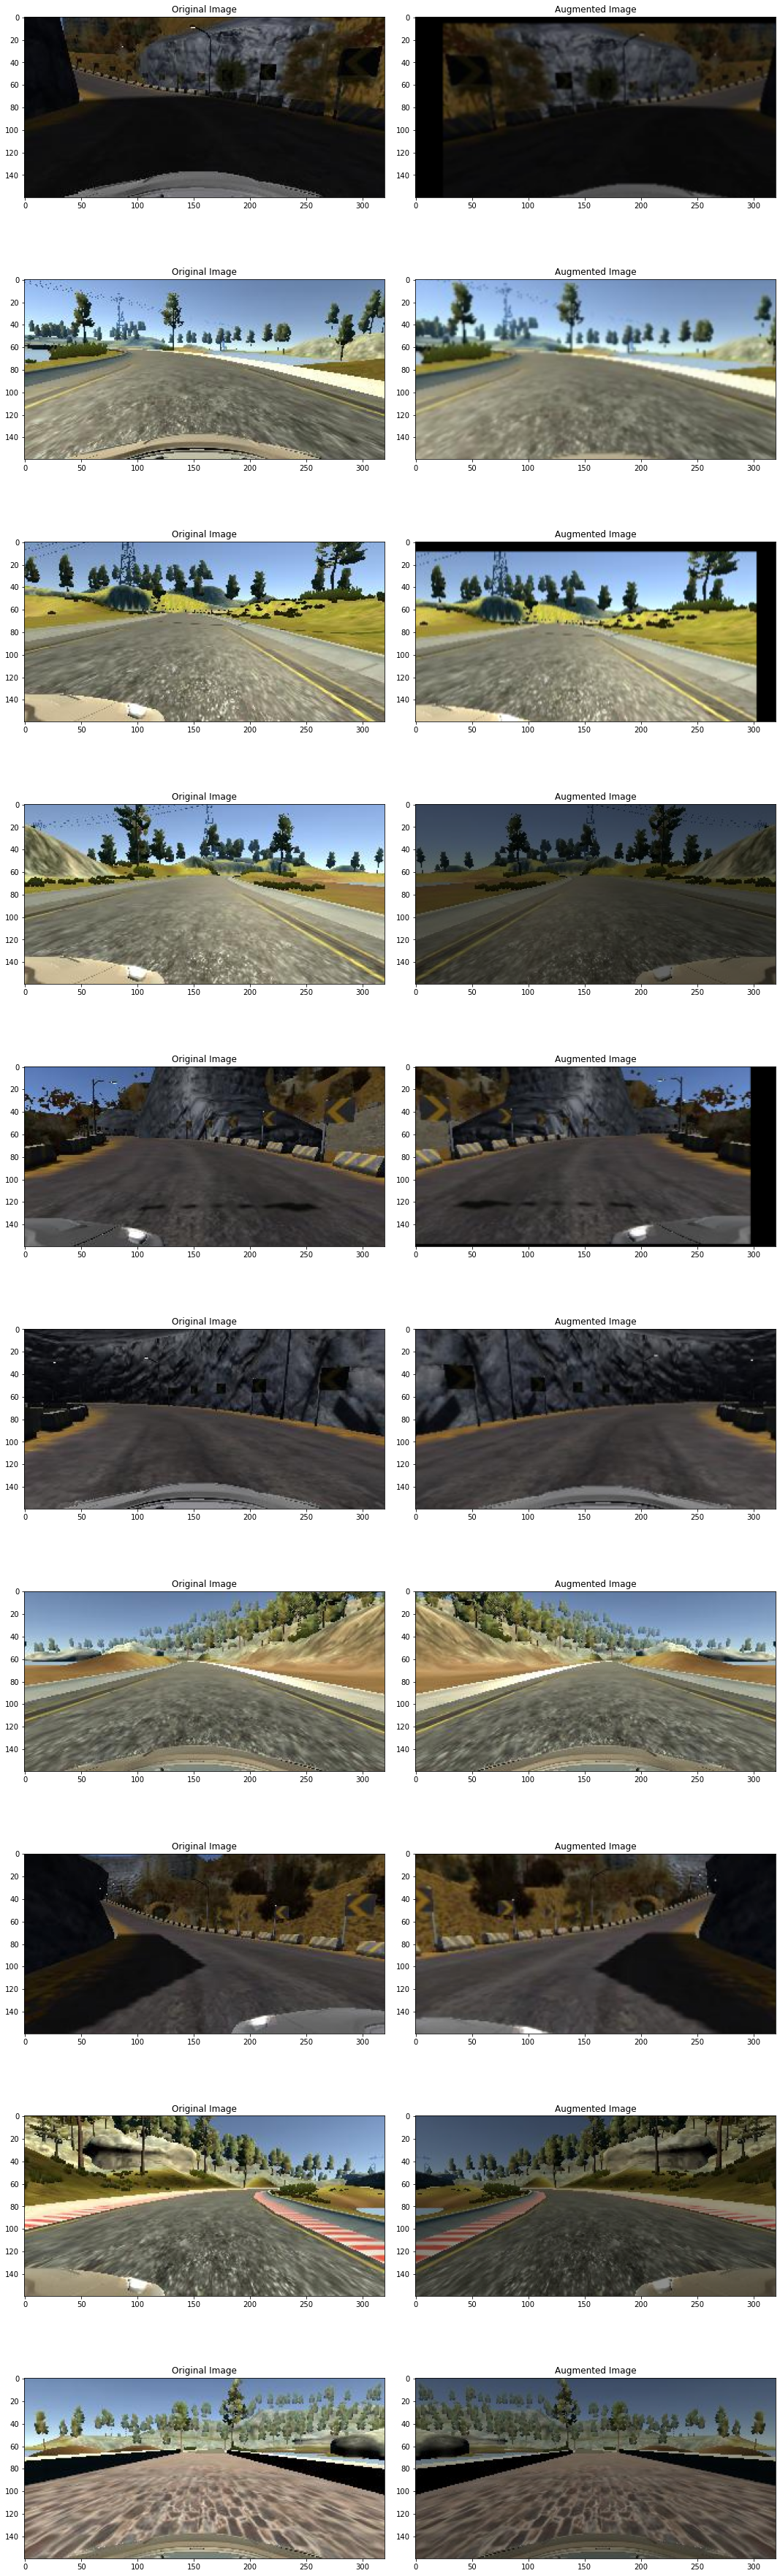

In [21]:
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
    randnum = random.randint(0, len(image_paths) - 1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]
    
    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)
    
    axs[i][0].imshow(original_image)
    axs[i][0].set_title("Original Image")
  
    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title("Augmented Image")

In [22]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

Text(0.5, 1.0, 'Preprocessed Image')

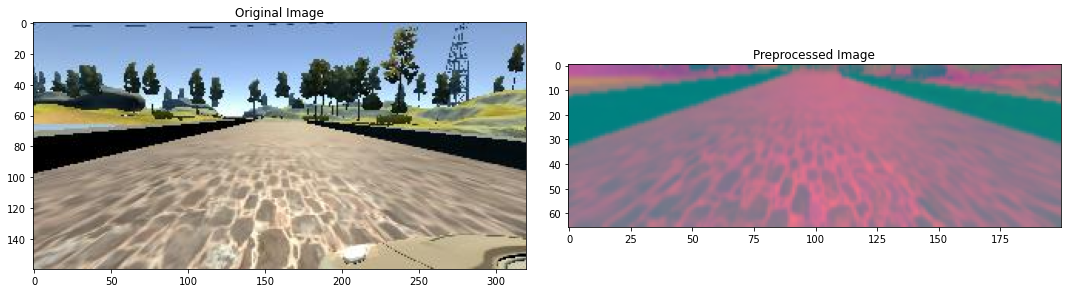

In [23]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [26]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
    while True:
        batch_img = []
        batch_steering = []
    
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
      
            if istraining:
                im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
            else:
                im = mpimg.imread(image_paths[random_index])
                steering = steering_ang[random_index]
      
            im = img_preprocess(im)
            batch_img.append(im)
            batch_steering.append(steering)
        yield (np.asarray(batch_img), np.asarray(batch_steering)) 

Text(0.5, 1.0, 'Validation Image')

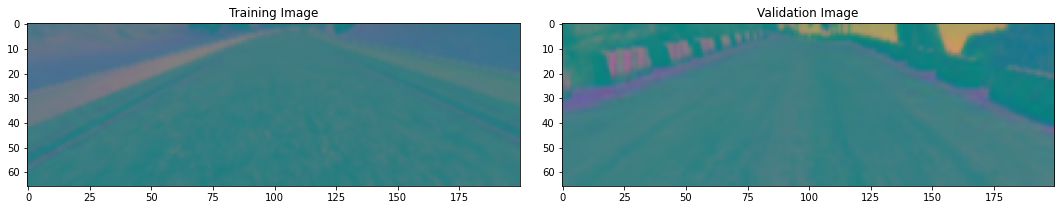

In [27]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [33]:
def nvidia_model():
 
    model = Sequential()
 
    model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='relu'))
 
    model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
    model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
    model.add(Dropout(0.45))
 
 
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(0.4))
 
 
    model.add(Dense(50, activation='elu'))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation ='elu'))
    model.add(Dense(1))
 
 
    optimizer= Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
 
    return model

In [37]:
model = nvidia_model()
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

In [38]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=17,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Epoch 1/17
300/300 [==============================] - 158s 528ms/step - loss: 0.0837 - accuracy: 0.0823 - val_loss: 0.0422 - val_accuracy: 0.0840
Epoch 2/17
300/300 [==============================] - 160s 532ms/step - loss: 0.0498 - accuracy: 0.0837 - val_loss: 0.0367 - val_accuracy: 0.0840
Epoch 3/17
300/300 [==============================] - 153s 510ms/step - loss: 0.0466 - accuracy: 0.0860 - val_loss: 0.0289 - val_accuracy: 0.0903
Epoch 4/17
300/300 [==============================] - 151s 505ms/step - loss: 0.0438 - accuracy: 0.0845 - val_loss: 0.0273 - val_accuracy: 0.0865
Epoch 5/17
300/300 [==============================] - 151s 504ms/step - loss: 0.0411 - accuracy: 0.0843 - val_loss: 0.0290 - val_accuracy: 0.0891
Epoch 6/17
300/300 [==============================] - 152s 508ms/step - loss: 0.0418 - accuracy: 0.0851 - val_loss: 0.0258 - val_accuracy: 0.0825
Epoch 7/17
300/300 [==============================] - 151s 502ms/step - loss: 0.0397 - accuracy: 0.0843 - val_loss: 0.0263 -

Text(0.5, 0, 'Epoch')

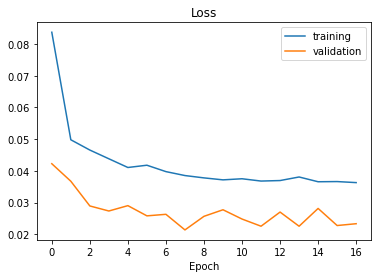

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [40]:
model.save('behaviour_cloning/model3.h5')